In [2]:
# Import necessary libraries
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pickle

# Upload the CSV file
uploaded = files.upload()

# Load the dataset, skipping the first 2 rows and setting up the date column
file_name = 'stock_data.csv'  # Adjust if the filename differs
stock_data = pd.read_csv(file_name, skiprows=[1], parse_dates=['Date'])
stock_data.set_index('Date', inplace=True)

# Preview the data
stock_data.head()


Saving stock_data.csv to stock_data (1).csv


,Close,High,Low,Open,Volume,MA_20,MA_50,RSI,MACD,Signal_Line,Returns
Date,,,,,,,,,,,
03-01-2020,72.088295,72.851761,71.862892,72.020432,146322800,NaN,NaN,NaN,-0.056458,-0.011292,-0.009722
06-01-2020,72.662712,72.701492,70.954002,71.206070,118387200,NaN,NaN,NaN,-0.054226,-0.019878,0.007968
07-01-2020,72.320961,72.929306,72.100403,72.672394,108872000,NaN,NaN,NaN,-0.079121,-0.031727,-0.004703
08-01-2020,73.484383,73.787346,72.022887,72.022887,132079200,NaN,NaN,NaN,-0.004915,-0.026365,0.016087
09-01-2020,75.045219,75.239113,74.213890,74.465950,170108400,NaN,NaN,NaN,0.177790,0.014466,0.021240


In [3]:
# Upload the trained model
uploaded_model = files.upload()

# Load the trained model
with open('trained_model.pkl', 'rb') as file:
    trained_model = pickle.load(file)

print("Trained model loaded successfully!")


Saving trained_model.pkl to trained_model.pkl
Trained model loaded successfully!


In [6]:
# Define features and target
X = stock_data[['Close', 'High', 'Low', 'Open', 'Volume', 'MA_20', 'MA_50', 'RSI', 'MACD', 'Signal_Line', 'Returns']]
y = (stock_data['Close'].shift(-1) > stock_data['Close']).astype(int)  # Predict next-day movement
X = X[:-1]  # Remove the last row (no future data for prediction)
y = y[:-1]

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X, y)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Optimized model
optimized_model = grid_search.best_estimator_


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [8]:
def simulate_trades_with_risk_management(data, model, stop_loss_pct=0.02, take_profit_pct=0.04, transaction_cost=0.001):
    predictions = model.predict(data)
    cash = 100000  # Starting cash
    position = 0  # Current position
    equity_curve = []

    for i in range(len(data) - 1):
        current_price = data['Close'].iloc[i]
        next_day_price = data['Close'].iloc[i + 1]
        prediction = predictions[i]

        # Simulate buy or sell
        if prediction == 1 and position == 0:  # Buy
            position = cash * (1 - transaction_cost) / current_price
            cash = 0

        elif prediction == 0 and position > 0:  # Sell
            cash = position * current_price * (1 - transaction_cost)
            position = 0

        # Apply stop-loss and take-profit
        if position > 0:
            max_loss = current_price * (1 - stop_loss_pct)
            target_profit = current_price * (1 + take_profit_pct)
            if next_day_price <= max_loss or next_day_price >= target_profit:
                cash = position * next_day_price * (1 - transaction_cost)
                position = 0

        # Calculate equity
        equity = cash + (position * next_day_price if position > 0 else 0)
        equity_curve.append(equity)

    return equity_curve

# Generate equity curve
equity_curve = simulate_trades_with_risk_management(stock_data.iloc[:-1], optimized_model)


In [9]:
# Cumulative Returns
cumulative_returns = (equity_curve[-1] - equity_curve[0]) / equity_curve[0]

# Sharpe Ratio
daily_returns = np.diff(equity_curve) / equity_curve[:-1]
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)

# Maximum Drawdown
drawdowns = 1 - np.array(equity_curve) / np.maximum.accumulate(equity_curve)
max_drawdown = np.max(drawdowns)

print(f"Cumulative Returns: {cumulative_returns:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")


Cumulative Returns: 34193.72%
Sharpe Ratio: 8.48
Maximum Drawdown: 4.29%


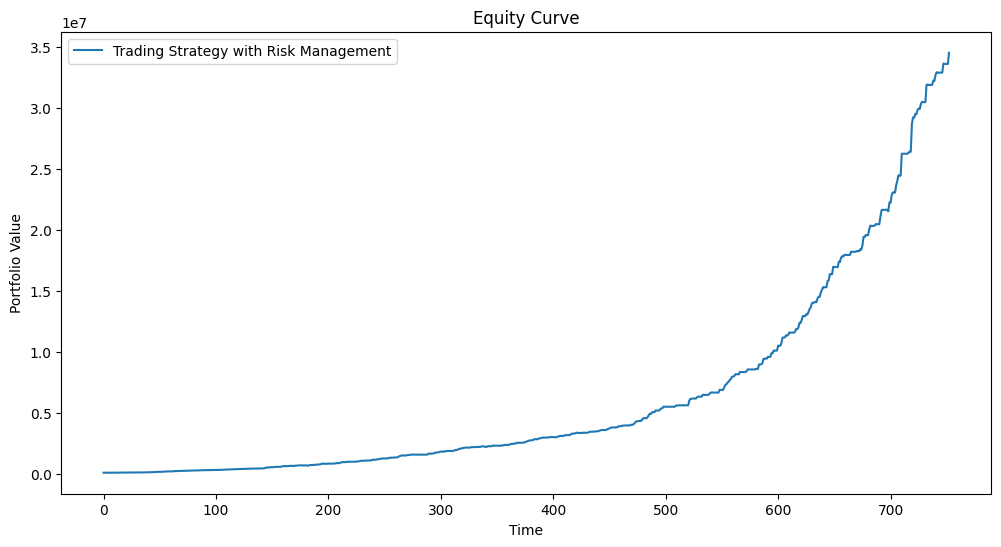

In [10]:
# Plot the equity curve
plt.figure(figsize=(12, 6))
plt.plot(equity_curve, label='Trading Strategy with Risk Management')
plt.title('Equity Curve')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


In [11]:
# Save the optimized model
with open('optimized_model.pkl', 'wb') as file:
    pickle.dump(optimized_model, file)

# Download the file
files.download('optimized_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>